In [1]:
# Check GPU Status in Google Colob or Local Machine
!nvidia-smi  # For GPU

Sun May  4 10:45:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Check if GPU is available with pytorch
import torch
print(torch.cuda.is_available()) # True if GPU is avilable

True


In [3]:
from google.colab import drive  # for mounting google drive if needed
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Install necessary libraries for YOLOv8 and COCO dataset handling
!pip install ultralytics
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import os # Provides functions for interacting with the operating system
import json # used to read and parse JSON files
from pathlib import Path # for handling and manipulating file paths

def coco_to_yolo_bbox(coco_json_path, images_dir, output_labels_dir):
    """
    Convert COCO format annotations (in JSON) to YOLOv8 bounding box format.

    Args:
        coco_json_path (str): Path to the input COCO JSON annotation file.
        images_dir (str): Path to the directory containing images (not used here directly).
        output_labels_dir (str): Path where YOLO-format label .txt files will be saved.
    """
    # Load the COCO JSON file
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # create a mapping from coco category ids to yolo class indices
    category_mapping = {category['id']: idx for idx, category in enumerate(coco_data['categories'])}

    # Create output directory if it doesn't exist
    os.makedirs(output_labels_dir, exist_ok=True)

    # iterate through each image entry in the coco dataset
    for image in coco_data['images']:
        image_id = image['id'] # unique image id
        image_filename = image['file_name'] # image file name
        img_width, img_height = image['width'], image['height'] # image width and height

        # create the output path for the label file
        label_path = os.path.join(output_labels_dir, f"{Path(image_filename).stem}.txt")

        # Open label file for writing
        with open(label_path, 'w') as label_file:
            # Get annotations for this image
            annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

            # Process each annotation(bounding box for the image)
            for ann in annotations:
                category_id = ann['category_id'] # Coco category id
                class_idx = category_mapping[category_id] # yolo class index

                # Extract and normalize bounding box
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height

                # Clip values to [0, 1] range
                x_center = min(max(x_center, 0), 1)
                y_center = min(max(y_center, 0), 1)
                w_norm = min(max(w_norm, 0), 1)
                h_norm = min(max(h_norm, 0), 1)

                # Write YOLO bbox line
                label_file.write(f"{class_idx} {x_center} {y_center} {w_norm} {h_norm}\n")

    print(f"[INFO] Converted annotations from: {coco_json_path} ➝ {output_labels_dir}")


In [ ]:
# === Step 1: Convert COCO to YOLOv8 Format for All Splits ===
# Define the base directory where original COCO-format dataset is stored
base_dir = '/content/drive/MyDrive/project_265/Dataset'

# Define the base output directory where YOLO-formatted labels will be saved
output_base_dir = '/content/drive/MyDrive/project_265/Yolo_conversion'
splits = ['train', 'val', 'test']

# Loop through each dataset split
for split in splits:
    # path to coco json annotation file for this split
    coco_json_path = f"{base_dir}/{split}/{split}.json"
    images_dir = f"{base_dir}/{split}/images" # path to image directory for the split
    # Path where YOLO-format label .txt files should be saved
    output_labels_dir = f"{output_base_dir}/{split}/labels"

    # Call the conversion function to convert COCO to YOLOv8 format
    coco_to_yolo_bbox(coco_json_path, images_dir, output_labels_dir)

print("[INFO] All COCO annotations converted to YOLOv8 bounding box format.")


[INFO] Converted annotations from: /content/drive/MyDrive/project_265/Dataset/train/train.json ➝ /content/drive/MyDrive/project_265/Yolo_conversion/train/labels
[INFO] Converted annotations from: /content/drive/MyDrive/project_265/Dataset/val/val.json ➝ /content/drive/MyDrive/project_265/Yolo_conversion/val/labels
[INFO] Converted annotations from: /content/drive/MyDrive/project_265/Dataset/test/test.json ➝ /content/drive/MyDrive/project_265/Yolo_conversion/test/labels
[INFO] All COCO annotations converted to YOLOv8 bounding box format.


In [ ]:
# === Step 2: Create dataset.yaml File Automatically ===
# Prompt the user to enter the full path to the COCO annotation JSON file (usually train.json)
coco_json_path = input("\nEnter the full path of your COCO JSON file (e.g., train_annotations.json): ")

# Prompt the user to enter the base output directory for the converted YOLO dataset
output_base_dir = input("Enter the base output directory for the converted dataset (e.g., '/content/drive/MyDrive/Yolo_conversions/'): ")

# Load JSON and extract class information
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# Extract the list of classes names from the 'categories' field in the json
class_names = [cat['name'] for cat in coco_data['categories']]

# Build a dictionary in the format expected by YOLOv8 for dataset.yam
dataset_yaml = {
    'train': os.path.join(output_base_dir, 'train/images'), # path for training images
    'val': os.path.join(output_base_dir, 'val/images'),     # path for validation images
    'test': os.path.join(output_base_dir, 'test/images'),   # path for test images
    'nc': len(class_names),                                 # number of classes
    'names': class_names                                    # list of classes
}

# define the ful path where dataset.yanl will be saved
yaml_output_path = os.path.join(output_base_dir, 'dataset.yaml')

# write the dataset.yaml dictionary to a yaml file
with open(yaml_output_path, 'w') as yaml_file:
    yaml.dump(dataset_yaml, yaml_file)

# notify the user that the yaml file was successfully created
print(f"[INFO] dataset.yaml created at: {yaml_output_path}")


Enter the full path of your COCO JSON file (e.g., train_annotations.json): /content/drive/MyDrive/project_265/Dataset/train/train.json
Enter the base output directory for the converted dataset (e.g., '/content/drive/MyDrive/Yolo_conversions/'): /content/drive/MyDrive/project_265/Yolo_conversion
[INFO] dataset.yaml created at: /content/drive/MyDrive/project_265/Yolo_conversion/dataset.yaml


In [45]:
from ultralytics import YOLO

# Step 1: Load the pre-trained YOLOv8 model (small version in this case)
model = YOLO('yolov8s.pt')  # You can switch to yolov8m.pt, yolov8l.pt, or yolov8x.pt based on your resources

# Step 2: Train the YOLOv8 model
results = model.train(
    data="/content/drive/MyDrive/project_265/Yolo_conversion/dataset.yaml",  # Path to dataset YAML file
    epochs=25,            # Number of epochs
    imgsz=640,            # Image size for training (640x640)
    batch=6,              # Batch size (adjust based on GPU memory)
    lr0=0.001,            # Initial learning rate
    workers=2,            # Number of data loader workers (parallel loading)
    optimizer="AdamW",    # Optimizer (AdamW is a good choice for many cases)
    patience=5,           # Early stopping if no improvement for 5 epochs
    device=0              # Device to use (0 for GPU, 'cpu' for CPU)
)

# Step 3: Output the results
print(f"Training completed! Model results: {results}")


Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/project_265/Yolo_conversion/dataset.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=5, perspective=0

train: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265/Yolo_conversion/train/labels.cache... 2236 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2236/2236 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 3.7±3.8 ms, read: 39.0±25.1 MB/s, size: 96.6 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265/Yolo_conversion/val/labels.cache... 639 images, 0 backgrounds, 0 corrupt: 100%|██████████| 639/639 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.000515625), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      1.49G      1.339      2.611      1.507         25        640: 100%|██████████| 373/373 [01:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.04it/s]

                   all        639       2306      0.391       0.37      0.303      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.01G      1.286      2.162      1.492         26        640: 100%|██████████| 373/373 [01:05<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.33it/s]


                   all        639       2306      0.417      0.517      0.428      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.04G      1.245      1.925      1.451         30        640: 100%|██████████| 373/373 [01:06<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.23it/s]


                   all        639       2306      0.501      0.562      0.529      0.374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.04G      1.161      1.671       1.38         45        640: 100%|██████████| 373/373 [01:05<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.27it/s]


                   all        639       2306      0.564      0.672      0.651      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.04G      1.076      1.468      1.321         23        640: 100%|██████████| 373/373 [01:06<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.74it/s]


                   all        639       2306      0.678      0.714      0.748      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.04G      1.037      1.357      1.296         23        640: 100%|██████████| 373/373 [01:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.24it/s]


                   all        639       2306      0.696      0.717      0.788       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.06G     0.9551      1.212      1.237         12        640: 100%|██████████| 373/373 [01:06<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.89it/s]


                   all        639       2306      0.746      0.786      0.847      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.08G     0.9096      1.086      1.191         16        640: 100%|██████████| 373/373 [01:06<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.23it/s]


                   all        639       2306      0.799      0.791      0.875      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.08G     0.8572     0.9926      1.158         11        640: 100%|██████████| 373/373 [01:06<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.89it/s]


                   all        639       2306      0.881      0.796      0.912      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.08G     0.8421     0.9426      1.155         40        640: 100%|██████████| 373/373 [01:06<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.28it/s]

                   all        639       2306      0.849      0.865      0.934      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.08G     0.8048     0.8682       1.13         31        640: 100%|██████████| 373/373 [01:07<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:08<00:00,  6.07it/s]

                   all        639       2306      0.877      0.873      0.941      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      2.08G      0.765     0.8174      1.105         15        640: 100%|██████████| 373/373 [01:06<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.22it/s]


                   all        639       2306       0.88      0.906      0.948      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.08G     0.7434      0.772      1.096         32        640: 100%|██████████| 373/373 [01:06<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.97it/s]

                   all        639       2306       0.88      0.903      0.952      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.08G     0.7206     0.7312      1.082         45        640: 100%|██████████| 373/373 [01:06<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.28it/s]


                   all        639       2306      0.914      0.904      0.961      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.08G     0.6835     0.6851       1.06         35        640: 100%|██████████| 373/373 [01:06<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.70it/s]


                   all        639       2306      0.949      0.905      0.969       0.85
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.08G     0.5791      0.548     0.9817         15        640: 100%|██████████| 373/373 [01:06<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.20it/s]


                   all        639       2306      0.922      0.932      0.974       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.08G     0.5361     0.4783     0.9545         13        640: 100%|██████████| 373/373 [01:03<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.23it/s]

                   all        639       2306      0.936      0.921      0.972      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.08G     0.5186     0.4446     0.9449         14        640: 100%|██████████| 373/373 [01:04<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.88it/s]


                   all        639       2306      0.947      0.939      0.978      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.08G     0.4856     0.4116     0.9247         14        640: 100%|██████████| 373/373 [01:04<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:09<00:00,  5.84it/s]

                   all        639       2306      0.943      0.948       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.08G     0.4737     0.3856     0.9129         14        640: 100%|██████████| 373/373 [01:04<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.24it/s]

                   all        639       2306      0.952      0.952      0.983      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.08G     0.4449     0.3576     0.9009         15        640: 100%|██████████| 373/373 [01:04<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.35it/s]


                   all        639       2306      0.948      0.941      0.983      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.08G       0.42     0.3351      0.889         16        640: 100%|██████████| 373/373 [01:04<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:08<00:00,  6.19it/s]

                   all        639       2306      0.952      0.951      0.981      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.08G     0.4092     0.3225     0.8877          9        640: 100%|██████████| 373/373 [01:04<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.29it/s]


                   all        639       2306      0.958      0.951      0.983       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.08G     0.3929     0.3061     0.8763          7        640: 100%|██████████| 373/373 [01:03<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:10<00:00,  5.25it/s]

                   all        639       2306      0.961      0.954      0.984      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.08G     0.3819     0.2973     0.8763         13        640: 100%|██████████| 373/373 [01:05<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:08<00:00,  6.00it/s]


                   all        639       2306      0.962      0.951      0.985      0.922

25 epochs completed in 0.532 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:11<00:00,  4.57it/s]


                   all        639       2306      0.963      0.951      0.985      0.922
          Gas Cylinder         58        267      0.971      0.993      0.994       0.95
      Fire Extingusher         73        321      0.946      0.937      0.975      0.879
Hydraulic/Pneaumatic cylinder        114        284      0.978      0.934      0.979      0.876
Aerosil cans/Paint tins         64        268      0.941      0.957      0.986      0.951
           Compressors         49        206      0.995      0.979      0.995      0.967
           Oil Filters         71        195      0.964      0.964      0.991      0.943
      Fuel tanks/ Cans        106        230      0.987      0.909      0.978      0.933
             Batteries         79        316      0.944      0.967      0.987      0.929
     Ammunition Shells         40        219      0.944      0.919       0.98      0.867
Speed: 0.4ms preprocess, 4.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to run

In [46]:
# === Step: Run Validation on the Trained Model ===
print("\n[INFO] Validating the model on validation dataset...")
val_results = model.val()

# === Step: Print Validation Results ===
print(f"\n[RESULT] Validation Results:")
print(f" - mAP@0.5:       {val_results.box.map50:.4f}")
print(f" - mAP@0.5:0.95:  {val_results.box.map:.4f}")
print(f" - Precision:     {val_results.box.mp:.4f}")
print(f" - Recall:        {val_results.box.mr:.4f}")




[INFO] Validating the model on validation dataset...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,067 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.9 ms, read: 45.8±46.3 MB/s, size: 137.1 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265/Yolo_conversion/val/labels.cache... 639 images, 0 backgrounds, 0 corrupt: 100%|██████████| 639/639 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 107/107 [00:14<00:00,  7.15it/s]


                   all        639       2306       0.96       0.95      0.985      0.921
          Gas Cylinder         58        267      0.965      0.985      0.993      0.948
      Fire Extingusher         73        321      0.943      0.931      0.975      0.879
Hydraulic/Pneaumatic cylinder        114        284      0.978      0.936      0.979      0.875
Aerosil cans/Paint tins         64        268      0.939      0.955      0.986      0.953
           Compressors         49        206      0.995       0.98      0.995      0.965
           Oil Filters         71        195      0.961      0.964      0.991      0.945
      Fuel tanks/ Cans        106        230      0.977      0.912      0.978      0.933
             Batteries         79        316      0.941      0.967      0.986      0.925
     Ammunition Shells         40        219      0.942      0.922       0.98      0.867
Speed: 0.6ms preprocess, 7.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to run

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


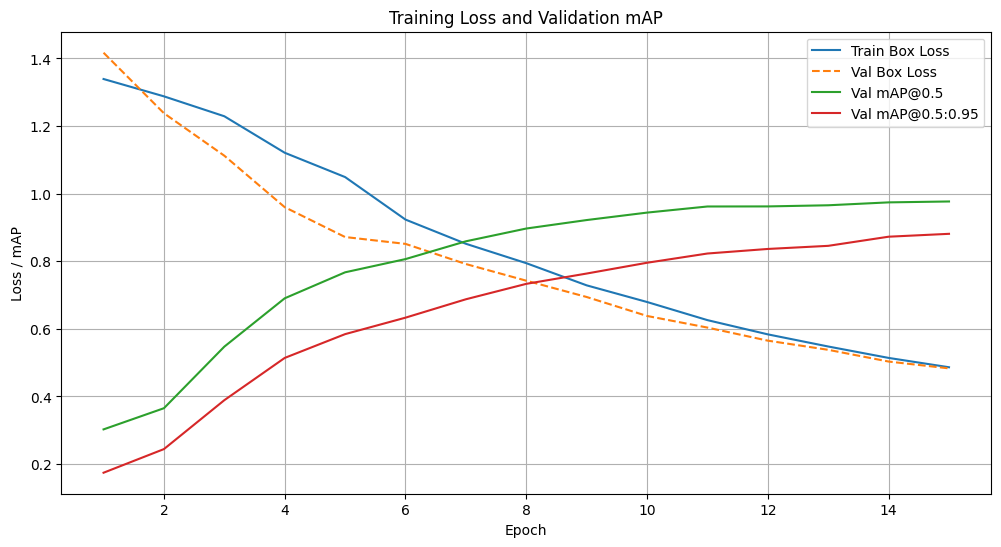

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Load results.csv from the training run
results_df = pd.read_csv('/content/runs/detect/train2/results.csv')

# Print actual column names to avoid KeyErrors
print(results_df.columns)

plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='Val mAP@0.5')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='Val mAP@0.5:0.95')

plt.xlabel('Epoch')
plt.ylabel('Loss / mAP')
plt.title('Training Loss and Validation mAP')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
metrics = model.val(split='test')  # Use test images as defined in dataset.yaml
print(metrics)


Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 13.9±30.0 ms, read: 10.2±8.1 MB/s, size: 107.8 KB)


val: Scanning /content/drive/.shortcut-targets-by-id/1Hf9Ogdqt_wuqBJs8ULea5YSJrxs4jgvK/project_265/Yolo_conversion/test/labels.cache... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:07<00:00,  7.29it/s]


                   all        320       1095      0.984      0.977       0.99      0.942
          Gas Cylinder         24        114      0.977      0.991      0.993      0.943
      Fire Extingusher         28        121      0.992      0.984      0.995      0.934
Hydraulic/Pneaumatic cylinder         50        110      0.999      0.973      0.991       0.89
Aerosil cans/Paint tins         25        113      0.956      0.965      0.993      0.965
           Compressors         24         93          1      0.978      0.991      0.943
           Oil Filters         62        205      0.966      0.976      0.993      0.963
      Fuel tanks/ Cans         59        128      0.998      0.977      0.991      0.968
             Batteries         28         99      0.976       0.99      0.994      0.966
     Ammunition Shells         25        112      0.994      0.955      0.964      0.909
Speed: 0.7ms preprocess, 8.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to run

In [50]:
print("\n[RESULT] Test Set Evaluation Metrics:")
print(f" - mAP@0.5:       {metrics.box.map50:.4f}")
print(f" - mAP@0.5:0.95:  {metrics.box.map:.4f}")
print(f" - Precision:     {metrics.box.mp:.4f}")
print(f" - Recall:        {metrics.box.mr:.4f}")



[RESULT] Test Set Evaluation Metrics:
 - mAP@0.5:       0.9896
 - mAP@0.5:0.95:  0.9423
 - Precision:     0.9841
 - Recall:        0.9766


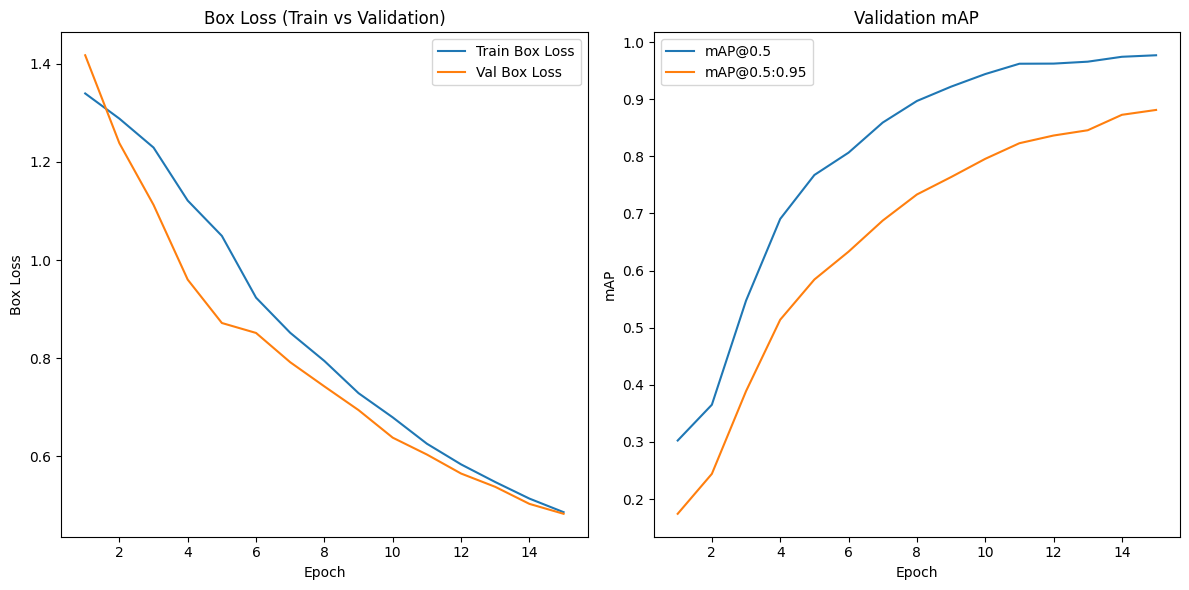

In [51]:
plt.figure(figsize=(12, 6))

# Plot box loss
plt.subplot(1, 2, 1)
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Box Loss (Train vs Validation)')
plt.legend()

# Plot mAP (adjust to correct column names)
plt.subplot(1, 2, 2)
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP')
plt.legend()

plt.tight_layout()
plt.show()


image 1/1 /content/drive/MyDrive/project_265/Yolo_conversion/12.jpg: 480x640 14 Hydraulic/Pneaumatic cylinders, 14.8ms
Speed: 6.0ms preprocess, 14.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)
Detected Objects Count per Class:
Class 2: 14 objects


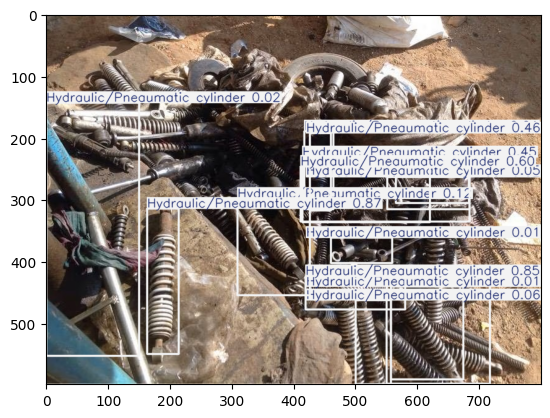


Detected Objects with Class Names:
Hydraulic/Pneaumatic cylinder: 14 objects


In [53]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Step 1: Load the trained YOLOv8 model (assuming you have a trained model)
# model = YOLO('/content/drive/MyDrive/yolov8_trained_model/best.pt')  # Path to your trained model

# Step 2: Make predictions on an image (single or batch)
image_path = '/content/drive/MyDrive/project_265/Yolo_conversion/12.jpg'  # Path to an image for inference
results = model.predict(image_path, conf = 0.01)  # Make predictions on the image

# Step 3: Count the number of objects for each class
detected_classes = results[0].boxes.cls.cpu().numpy()  # Extract class IDs from predictions

# Count the occurrences of each class
class_counts = {}
for cls in detected_classes:
    class_counts[int(cls)] = class_counts.get(int(cls), 0) + 1

# Print the count of objects per class
print("Detected Objects Count per Class:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} objects")

# Step 4: Optionally, show the image with bounding boxes and labels
# Visualize the results
plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
plt.show()
# Access the Results object from the list
results = results[0] # Get the Results object from the list

# Additional: You can use the class names from your dataset.yaml for better output
class_names = results.names  # If you want class names instead of IDs

print("\nDetected Objects with Class Names:")
for class_id, count in class_counts.items():
    print(f"{class_names[class_id]}: {count} objects")


In [54]:
print(f"Final Training Results Summary:")
print(f"📉 Final Train Box Loss: {results_df['train/box_loss'].iloc[-1]:.4f}")
print(f"📉 Final Val Box Loss: {results_df['val/box_loss'].iloc[-1]:.4f}")
print(f"✅ Final Val mAP@0.5: {results_df['metrics/mAP50(B)'].iloc[-1]:.4f}")
print(f"✅ Final Val mAP@0.5:0.95: {results_df['metrics/mAP50-95(B)'].iloc[-1]:.4f}")

print("\n[INFO] For test set:")
print(f"✅ Test mAP@0.5: {metrics.box.map50:.4f}")
print(f"✅ Test mAP@0.5:0.95: {metrics.box.map:.4f}")
print(f"✅ Test Precision: {metrics.box.mp:.4f}")
print(f"✅ Test Recall: {metrics.box.mr:.4f}")


Final Training Results Summary:
📉 Final Train Box Loss: 0.4864
📉 Final Val Box Loss: 0.4831
✅ Final Val mAP@0.5: 0.9769
✅ Final Val mAP@0.5:0.95: 0.8812

[INFO] For test set:
✅ Test mAP@0.5: 0.9896
✅ Test mAP@0.5:0.95: 0.9423
✅ Test Precision: 0.9841
✅ Test Recall: 0.9766


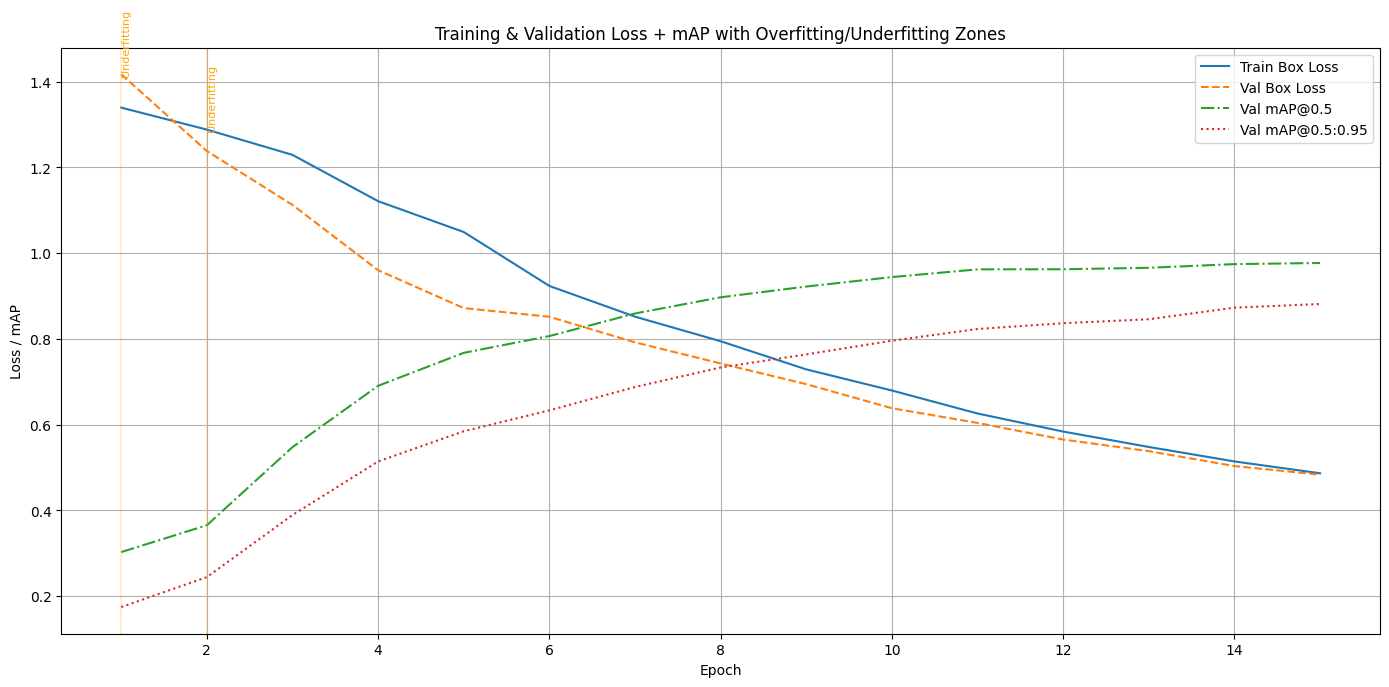

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Load training results
results_df = pd.read_csv('/content/drive/MyDrive/project_265/runs/detect/train2/results.csv')


# Plotting
plt.figure(figsize=(14, 7))

# Plot losses and mAP
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', linestyle='--')
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='Val mAP@0.5', linestyle='-.')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='Val mAP@0.5:0.95', linestyle=':')

# Annotate underfitting and overfitting zones
for epoch, train_loss, val_loss in zip(results_df['epoch'], results_df['train/box_loss'], results_df['val/box_loss']):
    if train_loss > 1.0 and val_loss > 1.0 and abs(train_loss - val_loss) < 0.1:
        plt.axvline(x=epoch, color='orange', alpha=0.2)
        plt.text(epoch, max(train_loss, val_loss), 'Underfitting', rotation=90, color='orange', fontsize=8)
    elif train_loss < 0.5 and val_loss > train_loss + 0.2:
        plt.axvline(x=epoch, color='red', alpha=0.2)
        plt.text(epoch, max(train_loss, val_loss), 'Overfitting', rotation=90, color='red', fontsize=8)

# Labels and formatting
plt.xlabel('Epoch')
plt.ylabel('Loss / mAP')
plt.title('Training & Validation Loss + mAP with Overfitting/Underfitting Zones')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
